In [26]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
df = pd.read_csv('FPT.csv', index_col='time', parse_dates=True)
df=df.drop(columns=['open', 'high', 'low', 'volume'])
df = df.reset_index(drop=True)
df.head()

,close
0,19318.330078
1,19491.587891
2,19448.273438
3,19318.330078
4,19383.300781


In [27]:
# 2. Đọc file csv và gắn index với Price
df1=df.reset_index()['close']

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [28]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for GRU
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [29]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 4s 60ms/step - loss: 0.0334 - val_loss: 0.0305
Epoch 2/100
14/14 [==============================] - 0s 23ms/step - loss: 0.0095 - val_loss: 0.0258
Epoch 3/100
14/14 [==============================] - 0s 24ms/step - loss: 0.0033 - val_loss: 0.0042
Epoch 4/100
14/14 [==============================] - 0s 24ms/step - loss: 4.4289e-04 - val_loss: 3.8683e-04
Epoch 5/100
14/14 [==============================] - 0s 23ms/step - loss: 2.6992e-04 - val_loss: 4.3085e-04
Epoch 6/100
14/14 [==============================] - 0s 25ms/step - loss: 1.5354e-04 - val_loss: 2.8429e-04
Epoch 7/100
14/14 [==============================] - 0s 24ms/step - loss: 1.4671e-04 - val_loss: 2.8940e-04
Epoch 8/100
14/14 [==============================] - 0s 23ms/step - loss: 1.3295e-04 - val_loss: 2.6535e-04
Epoch 9/100
14/14 [==============================] - 0s 25ms/step - loss: 1.2863e-04 - val_loss: 2.7175e-04
Epoch 10/100
14/14 [==============================] 

In [30]:
# Dự báo dữ liệu test
y_pred = model.predict(X_test)

# Chuẩn hóa dữ liệu y_pred
y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

12/12 [==============================] - 0s 6ms/step


In [31]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MAPE và MLSE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 2079.4136
MAPE trên tập test là: 1.530985627323389 %
MSLE trên tập test là: 0.0004583628


In [32]:
# Dự báo 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
lst_output = []

for i in range(30):
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:]).reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(y_hat.tolist())
    else:
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        lst_output.extend(y_hat.tolist())

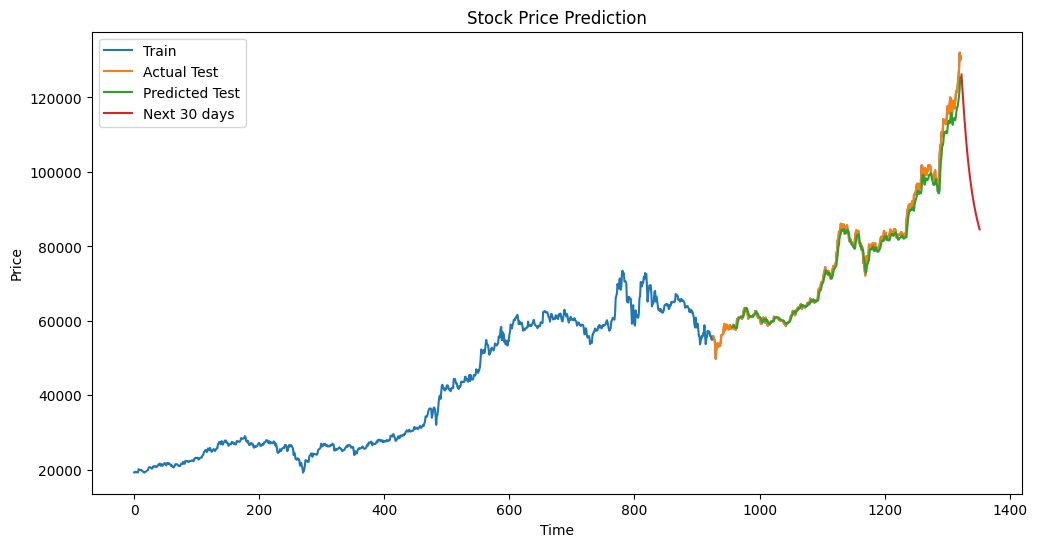

In [33]:
# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df1), label='Train')
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Actual Test')
test_pred_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + test_size - 1, step=1)
plt.plot(test_pred_index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Predicted Test')
predict_data_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output), label='Next 30 days')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()


# (Split 8/2)

In [34]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
df = pd.read_csv('FPT.csv', index_col='time', parse_dates=True)
df=df.drop(columns=['open', 'high', 'low', 'volume'])
df = df.reset_index(drop=True)
df.head()

,close
0,19318.330078
1,19491.587891
2,19448.273438
3,19318.330078
4,19383.300781


In [35]:
# 2. Đọc file csv và gắn index với Price
df1=df.reset_index()['close']

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [36]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for GRU
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [37]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 3s 52ms/step - loss: 0.0232 - val_loss: 0.0114
Epoch 2/100
17/17 [==============================] - 0s 22ms/step - loss: 0.0047 - val_loss: 0.0182
Epoch 3/100
17/17 [==============================] - 0s 22ms/step - loss: 9.0690e-04 - val_loss: 7.1236e-04
Epoch 4/100
17/17 [==============================] - 0s 23ms/step - loss: 2.0675e-04 - val_loss: 8.6150e-04
Epoch 5/100
17/17 [==============================] - 0s 21ms/step - loss: 1.4914e-04 - val_loss: 3.9630e-04
Epoch 6/100
17/17 [==============================] - 0s 24ms/step - loss: 1.3012e-04 - val_loss: 4.4056e-04
Epoch 7/100
17/17 [==============================] - 1s 33ms/step - loss: 1.2497e-04 - val_loss: 3.8816e-04
Epoch 8/100
17/17 [==============================] - 1s 35ms/step - loss: 1.2457e-04 - val_loss: 3.9889e-04
Epoch 9/100
17/17 [==============================] - 1s 32ms/step - loss: 1.2760e-04 - val_loss: 3.6915e-04
Epoch 10/100
17/17 [========================

In [38]:
# Dự báo dữ liệu test
y_pred = model.predict(X_test)

# Chuẩn hóa dữ liệu y_pred
y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

8/8 [==============================] - 1s 9ms/step


In [39]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MAPE và MLSE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 2243.091
MAPE trên tập test là: 1.7141133546829224 %
MSLE trên tập test là: 0.00051863893


In [40]:
# Dự báo 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
lst_output = []

for i in range(30):
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:]).reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(y_hat.tolist())
    else:
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        lst_output.extend(y_hat.tolist())

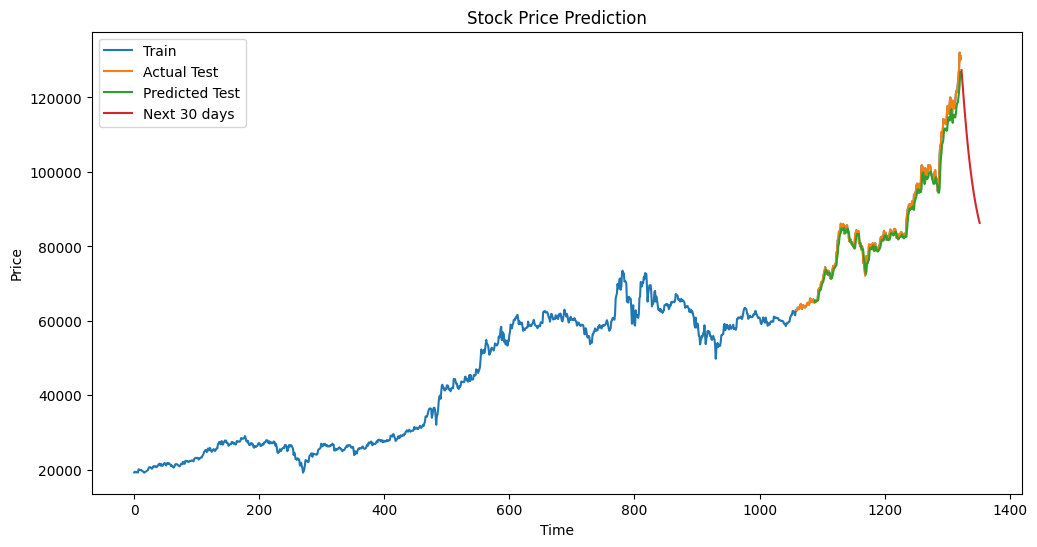

In [41]:
# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df1), label='Train')
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Actual Test')
test_pred_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + test_size - 1, step=1)
plt.plot(test_pred_index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Predicted Test')
predict_data_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output), label='Next 30 days')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()


# (Split 9/1)

In [42]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
df = pd.read_csv('FPT.csv', index_col='time', parse_dates=True)
df=df.drop(columns=['open', 'high', 'low', 'volume'])
df = df.reset_index(drop=True)
df.head()

,close
0,19318.330078
1,19491.587891
2,19448.273438
3,19318.330078
4,19383.300781


In [43]:
# 2. Đọc file csv và gắn index với Price
df1=df.reset_index()['close']

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [44]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for GRU
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [45]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
19/19 [==============================] - 3s 47ms/step - loss: 0.0329 - val_loss: 0.0183
Epoch 2/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0063 - val_loss: 0.0322
Epoch 3/100
19/19 [==============================] - 0s 23ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 4/100
19/19 [==============================] - 0s 20ms/step - loss: 2.0741e-04 - val_loss: 8.4515e-04
Epoch 5/100
19/19 [==============================] - 0s 20ms/step - loss: 1.6497e-04 - val_loss: 5.6522e-04
Epoch 6/100
19/19 [==============================] - 0s 22ms/step - loss: 1.4697e-04 - val_loss: 6.1528e-04
Epoch 7/100
19/19 [==============================] - 0s 20ms/step - loss: 1.4425e-04 - val_loss: 5.2348e-04
Epoch 8/100
19/19 [==============================] - 0s 23ms/step - loss: 1.4012e-04 - val_loss: 5.2341e-04
Epoch 9/100
19/19 [==============================] - 0s 20ms/step - loss: 1.3659e-04 - val_loss: 5.0017e-04
Epoch 10/100
19/19 [==============================] 

In [46]:
# Dự báo dữ liệu test
y_pred = model.predict(X_test)

# Chuẩn hóa dữ liệu y_pred
y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

4/4 [==============================] - 0s 6ms/step


In [47]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MAPE và MLSE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 2052.542
MAPE trên tập test là: 1.392162125557661 %
MSLE trên tập test là: 0.00037716998


In [48]:
# Dự báo 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
lst_output = []

for i in range(30):
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:]).reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(y_hat.tolist())
    else:
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        lst_output.extend(y_hat.tolist())

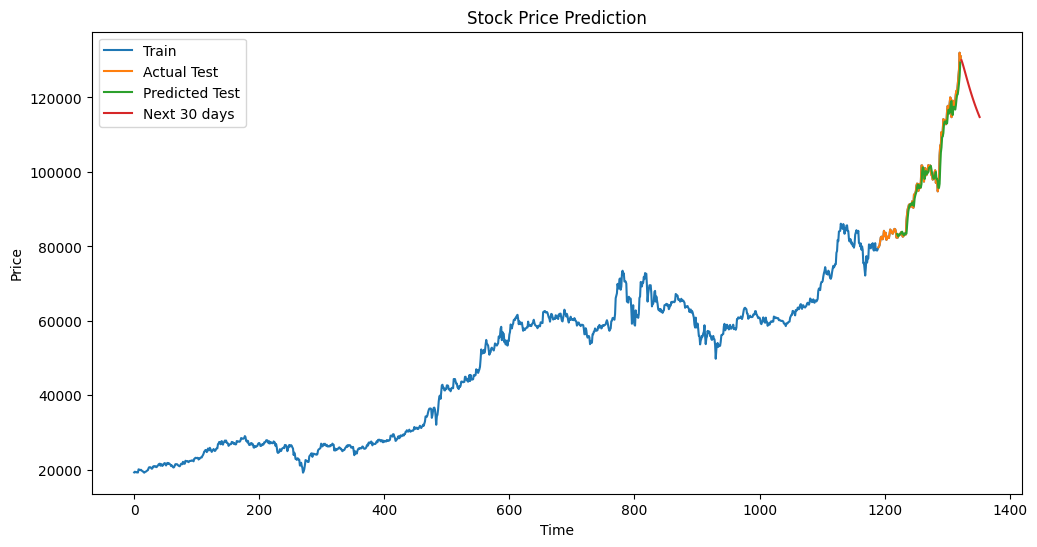

In [49]:
# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df1), label='Train')
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Actual Test')
test_pred_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + test_size - 1, step=1)
plt.plot(test_pred_index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Predicted Test')
predict_data_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output), label='Next 30 days')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()